<a href="https://colab.research.google.com/github/marcolinomsn/machine_learning/blob/main/Machine_Learning_%26_Analytics_(40530010055_202509).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: Machine Learning & Analytics

**Nome:** Marcolino Matheus de Souza Nascimento

**Data:** 28/09/2025

**Matrícula:** 4052025001107

**Dataset:** https://raw.githubusercontent.com/marcolinomsn/machine_learning/refs/heads/main/dataset.csv

# 1 - Escopo, objetivo e definição do problema
Existem diversos modelos meteorológicos de previsão do tempo. Eles podem prever diversas variáveis atmosféricas, sendo a precipitação a variável mais relevante na maioria das situações. A previsão de chuva pode ser desafiadora dependendo da região, do horizonte de previsão (quanto tempo no futuro a previsão diz respeito). Na empresa onde eu trabalho são armazenados diversos modelos meteorológicos de órgãos públicos e também executados internamente. O principal desafio é obter um modelo principal para ser utilizado e/ou a combinação dos modelos disponíveis para produzir algum ensemble.

## 1.1 - Atributos do Dataset
O dataset utilizado reúne rodadas de simulação (`run_datetime`) de múltiplos modelos, contendo previsões em diferentes horizontes de tempo e comparações com valores observados (`precipitation_obs`).

O conjunto de dados foi obtido a partir de um banco de dados da empresa onde eu trabalho. No entanto, são dados em grande maioria públicos, que podem ser acessados diariamente a partir de seus respectivos sites. A exceção são os modelos WRF NBT, WRF NBK e WRF NB7 que são produzidos na própria infra estruura da empresa. Os dados o bservados são oriundos de fontes públicas como o Instituto Nacional de Meteorologia.

**A tabela possui as seguintes colunas:**

`region`: Região foco da previsão do modelo. Foram extraídas previsões para 6 regiões do estado de Santa Catarina. O intuito foi concentrar a previsão de uma localidade com características meteorológicas em comum e ao mesmo tempo trazer um aumento no total de registros.

`state`: Unidade federativa de cada região. Não foi utilizado no experimento, pois as regiões estavam todas em SC.

`model`: Nome do modelo meteorológico numérico que gerou a previsão (ex.: ECMWF, GFS, ICON, WRF). Essa coluna é usada antes do pivot, onde cada modelo passa a ser uma variável independente.

`run_datetime`: Data e hora da rodada de simulação do modelo meteorológico (momento em que o modelo numérico foi inicializado).

`datetime`: Data e hora da previsão emitida (quando o modelo estima a chuva para o futuro). É usada em conjunto com run_datetime para calcular o horizonte de previsão.

`precipitation`: Valor previsto de precipitação (mm) por um modelo meteorológico específico. Após o pivot, cada modelo passa a ocupar uma coluna própria (ex.: GFS, ECMWF, ICON).

`precipitation_obs`: Valor observado de precipitação acumulada (mm) no local e período da previsão. É a variável alvo do problema de regressão.

**Criado no pré-processamento:**

`step` (criada no pré-processamento): Diferença em horas entre datetime e run_datetime. Representa o lead time da previsão (quantas horas à frente da rodada o modelo está prevendo).

`horizon` (criada no pré-processamento): Agrupamento de step em intervalos de previsão (24h, 48h, 72h, 96h, 120h). Facilita a análise de desempenho por prazos distintos.

## 1.2 - Tipo de Problema
 É um problema de regressão supervisionada em dados tabulares meteorológicos.

## 1.3 - Objetivo do experimento
O presente experimento tem como objetivo avaliar e melhorar previsões de chuva acumulada a partir de diferentes modelos meteorológicos de previsão do tempo.

## 1.4 - Metodologia do experimento

A previsão do tempo através de modelos tem uma particularidade e um desafio que é a **propagação de erros**.

**Propagação de erros**: Conforme o horizonte de previsão aumenta, os erros iniciais são propagados. Previsões de curto prazo (D+1, D+2) tendem a ser mais próximas da realidade, enquanto previsões de longo prazo (D+4, D+5) acumulam incertezas. Devido a isso, um atributo será adicionado para identificar o horizonte de previsão e particionar os dados. Assim,concentraremos o experimento apenas no horizonte de previsão de até 24 horas.

**A proposta do trabalho é**:
1. Carregar e organizar os dados, criando atributos derivados como horizonte de previsão.
2. Tratar valores ausentes e ajustar a distribuição da variável-alvo.
3. Comparar modelos candidatos (Lineares, Árvores e Ensemble) com um baseline simples.
4. Otimizar hiperparâmetros para buscar o melhor equilíbrio entre viés e variância.
5. Avaliar o desempenho com métricas adequadas (MAE, RMSE, Bias e R²) e analisar limitações.

Esse fluxo permite identificar qual modelo apresenta melhor desempenho preditivo. O resultado esperado é fornecer uma base metodológica para avaliar previsões meteorológicas de forma sistemática e reprodutível.

# 2 -  Reprodutibilidade e ambiente

## 2.1 - Importação das bibliotecas necessárias
Esta seção consolida todas as importações de bibliotecas necessárias para a análise, visualização e pré-processamento dos dados.

In [8]:
import random
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score,
    silhouette_score
)
from sklearn.model_selection import (
    KFold, StratifiedKFold, TimeSeriesSplit,
    train_test_split, cross_val_score,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingRegressor
)
from sklearn.cluster import KMeans
from xgboost import XGBRegressor

# 3 - Definição de funções

## 3.1 - Estatísticas (Observado vs previsto)

In [9]:
def evaluate_predictions(y_true, y_pred):
    """
    Compute evaluation metrics comparing predictions with observed values.

    Args:
        y_true: array-like, true observed values
        y_pred: array-like, predicted values (from model or raw forecasts)

    Return:
        dict: dictionary with metrics MAE, RMSE, R2 and BIAS.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    return {"MAE": mae, "RMSE": rmse, "Bias": bias, "R2": r2}


def statistical_metrics_analysis(dataset, features):
    """
    Compute error metrics for each forecast.

    Args:
        dataset: DataFrame containing observed and model forecasts.
        features: list of feature column names.

    Return:
        stats_df: DataFrame with MAE, RMSE, Bias and R2 for
            each forecast model and the mean model.
    """
    # Calculate metrics for each individual model
    stats = {}
    for feature in features:
        stats[feature] = evaluate_predictions(
            dataset.precipitation_obs,
            dataset[feature]
        )

    # DataFrame with results
    stats_df = pd.DataFrame(stats).T
    stats_df = stats_df.sort_values(by="R2", ascending=False)

    display(stats_df)
    return stats_df

## 3.2 - Visualização gráfica das estatísticas
Confecção de heatmap de correlação mostrando a relação entre cada modelo meteorológico e o valor observado de precipitação. Objetivo é identificar quais conjuntos de dados têm maior alinhamento com os dados observados e possíveis redundâncias (modelos muito correlacionados entre si).

In [10]:
def correlation_plot(dataset, features):
    """
    Plot correlation heatmap between observed and forecast models.

    Args:
        dataset: DataFrame containing observed and model forecasts.
    """
    data = dataset[features + ["precipitation_obs"]]
    mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    plt.figure(figsize=(6, 4))
    sns.heatmap(data.corr(), mask=mask, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title("Mapa de calor de correlação (modelos vs observados)")
    plt.show()


def statistical_metrics_plot(stats_df):
    """
    Plot statistical metrics between observed rainfall and forecast models.

    Args:
        stats_df: DataFrame with MAE, RMSE, R2, and Bias for each forecast model.
    """
    stats_df.plot(kind="barh", width=0.5)
    plt.xlabel("mm")
    plt.ylabel("")
    plt.yticks(rotation=0)
    plt.legend(title="Métricas")
    plt.tight_layout()
    plt.show()

## 2.2 - Seeds fixas para reprodutibilidade.

In [11]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


# 3 - Dados: Carga, entendimento e tratamento inicial


## 3.1 - Abertura do conjunto de dados

In [12]:
raw_dataset = pd.read_csv("https://raw.githubusercontent.com/marcolinomsn/machine_learning/refs/heads/main/dataset.csv")
display(raw_dataset.sample(5))

print("\nFormato:", raw_dataset.shape)

print("\n\nValores ausentes por coluna:\n")
print(raw_dataset.isna().sum())
print(f"\nQuantidade de modelos meteorológicos: {len(raw_dataset.model.unique())} ({', '.join(raw_dataset.model.unique())})")

run_datetimes = raw_dataset.run_datetime.unique()
print(f"Quantidade de simulações (rodadas): {len(raw_dataset.run_datetime.unique())} ({run_datetimes.min()} até {run_datetimes.max()})")

,region,state,model,run_datetime,datetime,precipitation,precipitation_obs
67812,BR-116 - 03 Mafra - SC,SC,WRF,2025-08-02 00:00:00+00:00,2025-08-03 21:00:00+00:00,0.00,0.11
341740,BR-116 - 05 Serra do Espigão - SC,SC,WRF NBK,2025-05-22 00:00:00+00:00,2025-05-23 03:00:00+00:00,0.01,0.07
314929,BR-116 - 05 Serra do Espigão - SC,SC,WRF,2025-07-09 00:00:00+00:00,2025-07-09 12:00:00+00:00,0.10,0.00
295478,BR-116 - 05 Serra do Espigão - SC,SC,ICON,2025-07-01 00:00:00+00:00,2025-07-01 14:00:00+00:00,0.00,0.00
14953,BR-116 - 03 Mafra - SC,SC,ECMWF,2025-08-23 00:00:00+00:00,2025-08-27 03:00:00+00:00,2.00,0.02



Formato: (457102, 7)


Valores ausentes por coluna:

region                   0
state                    0
model                    0
run_datetime             0
datetime                 0
precipitation            0
precipitation_obs    40325
dtype: int64

Quantidade de modelos meteorológicos: 7 (ECMWF, GFS, ICON, WRF, WRF NB7, WRF NBK, WRF NBT)
Quantidade de simulações (rodadas): 155 (2025-04-20 00:00:00+00:00 até 2025-09-21 00:00:00+00:00)


In [13]:
target = "precipitation_obs"
features = ["GFS", "ICON", "ECMWF", "WRF", "WRF NB7", "WRF NBK", "WRF NBT"]

print("Definição de features e target")
print("Target:", target)
print("N features:", len(features))

Definição de features e target
Target: precipitation_obs
N features: 7


## 3.5 - Reorganização do dataset

Aqui será feito a pivotagem do dataset para transformar as linhas que informam qual é o modelo meteorológico em colunas e, assim, reduzir consideravelmente a quantidade de linhas do conjunto. Isso é possível, pois para cada modelo existe um mesmo horário (datetime), ou seja, é possível ter uma coluna de datetime, seguida de colunas para cada modelo.

In [14]:
pivoted_dataset = raw_dataset.pivot_table(
    index=["run_datetime", "datetime", "precipitation_obs"],
    columns="model",
    values="precipitation"
).reset_index()
pivoted_dataset.columns.name = None

## 3.4 - Limpeza de dados

As simulações dos modelos não possuem dados nulos, pois é um dado sintetizado. Contudo, a coluna do dataset correspondente aos dados observados está suscetível à disponibilidades variáveis. Ausências de dados podem ocorrer devido a fatores diversos como manutenção, atraso, erros, etc. Então, será feita a limpeza dos horários que possuem NaN.

In [15]:
print("Realizando limpeza de dados nulos:")
print(f"- Total de linhas antes da limpeza: {len(pivoted_dataset)}")

valid_dataset = pivoted_dataset.dropna()
print(f"- Total de linhas após a limpeza: {len(valid_dataset)}")

Realizando limpeza de dados nulos:
- Total de linhas antes da limpeza: 28362
- Total de linhas após a limpeza: 17847


In [16]:
print("Adicionando feature de ensemble simples (MEAN_MODEL):")
valid_dataset = valid_dataset.copy()
valid_dataset.loc[:, "MEAN_MODEL"] = valid_dataset[features].mean(axis=1)
features.append("MEAN_MODEL")
print(f"Novo conjunto de features: {features}")

Adicionando feature de ensemble simples (MEAN_MODEL):
Novo conjunto de features: ['GFS', 'ICON', 'ECMWF', 'WRF', 'WRF NB7', 'WRF NBK', 'WRF NBT', 'MEAN_MODEL']


### 3.5.1 - Balanceamento de chuva e não chuva
Antes de treinar os modelos de previsão, é importante preparar os dados para reduzir vieses e facilitar a análise.
- O problema de previsão de chuva apresenta um desbalanceamento: cerca de 70% dos registros são dias sem chuva e apenas 30% têm chuva observada.
- Esse desbalanceamento pode fazer com que os modelos aprendam a “chutar sempre zero” e ainda assim tenham bons resultados em métricas superficiais.
- Para corrigir isso, separaremos o dataset em dois subconjuntos.
- Em seguida, é feito um subamostragem aleatória (undersampling) do conjunto sem chuva, pegando o mesmo número de linhas que existe no conjunto com chuva.
- Por fim, os dois subconjuntos são unidos, gerando um dataset balanceado (50% chuva, 50% sem chuva).

In [17]:
dataset_rain = valid_dataset[valid_dataset.precipitation_obs > 0]
dataset_no_rain = valid_dataset[valid_dataset.precipitation_obs == 0]

dataset_no_rain_sample = dataset_no_rain.sample(len(dataset_rain), random_state=42)

dataset_balanced = pd.concat([dataset_rain, dataset_no_rain_sample])
dataset_balanced = dataset_balanced.reset_index(drop=True)

print("Contagem de linhas:")
print(f"- Apenas chuva: {len(dataset_rain)}")
print(f"- Sem chuva: {len(dataset_no_rain)}")
print(f"- Dataset balanceado: {len(dataset_balanced)}")

Contagem de linhas:
- Apenas chuva: 5851
- Sem chuva: 11996
- Dataset balanceado: 11702


## 3.3 - Criando feature de horizonte da previsão

O horizonte da previsão é importante nesse tipo de dado, pois um modelo meteorológico executado em um dia D com o objetivo de realizar previsões para os horizontes D+0, D+1, D+2, entre outros, tende a apresentar maiores erros em função do aumento do horizonte previsão. Quanto maior for o horizonte, mais erros relacionados a condição inicial do experimento são propagados e influenciam nos resultados. Sendo assim, é plausível pensar que D+0, ou seja, uma previsão de menos de 24 horas, contenha menos erros propagados que uma previsão D+4, para mais de 96 horas. Seguinte essa lógica, o dataset será segmentado em horizontes e serão obtidos resultados diferentes para cada horizonte.

In [18]:
complete_dataset = dataset_balanced.copy()
complete_dataset.loc[:, "step"] = (
    pd.to_datetime(complete_dataset.datetime) - pd.to_datetime(complete_dataset.run_datetime)
).dt.total_seconds() / 3600

complete_dataset["horizon"] = pd.cut(
    complete_dataset["step"],
    bins=[0, 24, 48, 72, 96, 121],
    labels=[24, 48, 72, 96, 120],
    right=False
).astype(int)

In [19]:
dataset_24h = complete_dataset[complete_dataset.horizon == 24]
print(f"Apenas horizonte de 24 horas: {len(dataset_24h)}")

Apenas horizonte de 24 horas: 2330


## 3.6 - Análise estatística de previsões vs observado
Avaliação, antes de qualquer treinamento supervisionado, de como cada modelo meteorológico se compara ao valor observado de chuva.
Essa análise é importante para a conclusão do experimento a respeito de algum modelo meteorológico já se aproximar bem do observado ou se a combinação (ensemble) ser mais promissora.

`MAE (Mean Absolute Error)`: erro absoluto médio em relação à chuva observada.

`RMSE (Root Mean Squared Error)`: erro quadrático médio, que penaliza mais os erros grandes.

`R² (Coeficiente de Determinação)`: proporção da variabilidade da chuva observada que o modelo consegue explicar.

`Bias (tendência)`: se o modelo tende a superestimar ou subestimar a chuva.

,MAE,RMSE,Bias,R2
GFS,0.352622,1.127779,-0.049781,0.159560
ICON,0.362448,1.144504,-0.098273,0.134448
MEAN_MODEL,0.414054,1.262987,0.000244,-0.054039
WRF,0.433832,1.298930,0.007634,-0.114885
ECMWF,0.430916,1.306855,-0.022380,-0.128531
WRF NBT,0.530927,1.736246,0.069858,-0.991963
WRF NB7,0.540393,1.825013,0.054758,-1.200850
WRF NBK,0.546016,1.925447,0.039892,-1.449749


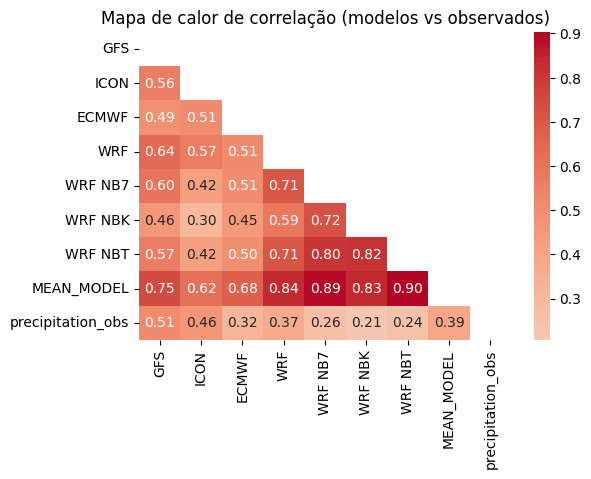

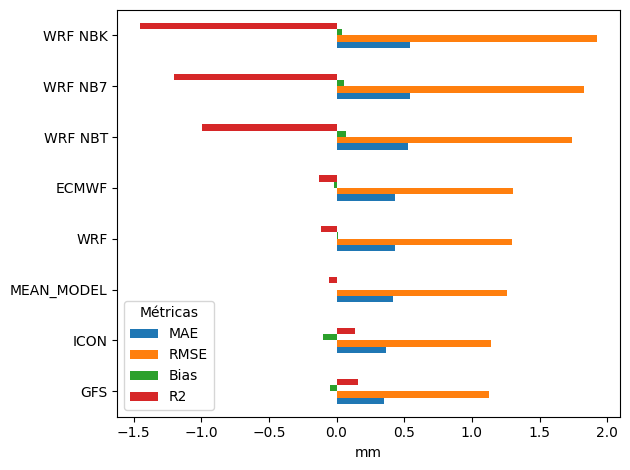

In [20]:
stats_df = statistical_metrics_analysis(dataset_24h, features)
correlation_plot(dataset_24h, features)
statistical_metrics_plot(stats_df)

# 4 - Divisão dos dados em conjunto de treino e teste

In [21]:
X = dataset_24h[features].copy()
y = dataset_24h[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "| Test:", X_test.shape)

Train: (1864, 8) | Test: (466, 8)


# 5 - **Pipeline** de pré-processamento
Criação de pipeline para tratar as variáveis numéricas:
- Substitui valores ausentes pela **mediana**.
- Aplica **padronização** (média = 0, desvio = 1).
- Mantém as demais colunas sem alteração.

Isso garante que os dados estejam preparados e em escala adequada antes do treinamento dos modelos.

In [22]:
num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_pipe, num_cols)],
    remainder="passthrough"
)

# 6 - Baseline e modelos candidatos
Criação de pipelines de regressão que serão testados:
- **Baseline**: um `DummyRegressor` que prevê sempre a mediana do target, servindo como referência mínima.
- **Modelos candidatos**: diferentes algoritmos de regressão, todos combinados com o pipeline de pré-processamento (`preprocess`), incluindo:
  - Regressões lineares (Linear, Ridge, Lasso)
  - Modelos de ensemble (RandomForest, GradientBoosting, XGBoost)

Essa etapa organiza todos os modelos em uma estrutura padronizada para facilitar o treinamento e a comparação de desempenho.

In [23]:
baseline = Pipeline(steps=[
    ("pre", preprocess),
    ("model", DummyRegressor(strategy="median"))
])

candidates = {
    "Linear": Pipeline([
        ("pre", preprocess), ("model", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("pre", preprocess), ("model", Ridge(alpha=1.0, random_state=SEED))
    ]),
    "Lasso": Pipeline([
        ("pre", preprocess), ("model", Lasso(alpha=0.01, random_state=SEED))
    ]),
    "RandomForest": Pipeline([
        ("pre", preprocess), ("model", RandomForestRegressor(
            n_estimators=300, max_depth=10, random_state=SEED, n_jobs=-1))
    ]),
    "GradientBoosting": Pipeline([
        ("pre", preprocess), ("model", GradientBoostingRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=5, random_state=SEED))
    ]),
    "XGBoost": Pipeline([
        ("pre", preprocess), ("model", XGBRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8, random_state=SEED))
    ])
}
baseline

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GFS', 'ICON', 'ECMWF',
                                                   'WRF', 'WRF NB7', 'WRF NBK',
                                                   'WRF NBT',
                                                   'MEAN_MODEL'])])),
                ('model', DummyRegressor(strategy='median'))])

# 7 - Treino e avaliação rápida (baseline vs candidatos)
Essa etapa compara diferentes modelos com um baseline simples, avaliando sua capacidade de generalizar para novos dados. O objetivo é identificar quais algoritmos realmente trazem ganhos em relação a uma referência mínima, considerando não só a qualidade das previsões, mas também o custo de treinamento.

In [24]:
results = {}

# Baseline
t0 = time.time()
baseline.fit(X_train, y_train)
t1 = time.time()

y_pred = baseline.predict(X_test)
results["baseline"] = evaluate_predictions(y_test, y_pred)
results["baseline"]["train_time_s"] = round(t1 - t0, 3)

# Candidates
for name, pipe in candidates.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()

    y_pred = pipe.predict(X_test)
    results[name] = evaluate_predictions(y_test, y_pred)
    results[name]["train_time_s"] = round(t1 - t0, 3)

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="R2", ascending=False)

print("Estatísticas de cada candidato (sem tuning):")
display(results_df)

Estatísticas de cada candidato (sem tuning):


,MAE,RMSE,Bias,R2,train_time_s
GradientBoosting,0.385396,1.150402,0.034587,0.377115,1.498
RandomForest,0.397626,1.154182,0.042227,0.373014,4.116
XGBoost,0.395433,1.170552,0.021046,0.355103,0.315
Linear,0.400575,1.207401,-0.035050,0.313861,0.065
Ridge,0.400623,1.207519,-0.035057,0.313727,0.078
Lasso,0.405931,1.217391,-0.033616,0.302460,0.065
baseline,0.388026,1.508387,-0.388026,-0.070865,0.034


# 8 - Validação e Otimização de Hiperparâmetros
O desempenho de um modelo depende tanto do algoritmo utilizado quanto dos valores escolhidos para seus hiperparâmetros, como profundidade das árvores ou número de estimadores. O processo de tuning de hiperparâmetros consiste em explorar diferentes combinações desses valores para encontrar o melhor equilíbrio entre viés e variância.

A validação cruzada é usada nesse processo para avaliar várias configurações de forma consistente, reduzindo a influência de divisões específicas do conjunto de treino e fornecendo uma escolha mais robusta do modelo final.

In [25]:
# Hyperparameter search space
PARAM_SPACES = {
    "Linear": {},
    "Ridge": {"model__alpha": uniform(0.01, 10)},
    "Lasso": {"model__alpha": uniform(0.001, 1)},
    "RandomForest": {
        "model__n_estimators": randint(100, 400),
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 10)
    },
    "GradientBoosting": {
        "model__n_estimators": randint(100, 400),
        "model__learning_rate": uniform(0.01, 0.2),
        "model__max_depth": randint(3, 10)
    },
    "XGBoost": {
        "model__n_estimators": randint(100, 400),
        "model__learning_rate": uniform(0.01, 0.2),
        "model__max_depth": randint(3, 10),
        "model__subsample": uniform(0.5, 0.5),
        "model__colsample_bytree": uniform(0.5, 0.5)
    }
}

best_models = {}
results = {}

for name, pipeline in candidates.items():
    print(f"\nTuning {name}...")

    # Define parameter space
    param_dist = PARAM_SPACES.get(name, {})

    # If there are no parameters to tune, just train directly
    if not param_dist:
        print(f"{name}: sem hiperparâmetros para tunar. Usando configuração padrão.")
        t0 = time.time()
        pipeline.fit(X_train, y_train)
        t1 = time.time()

        best_models[name] = pipeline
        y_pred = pipeline.predict(X_test)

        res = evaluate_predictions(y_test, y_pred)
        res["train_time_s"] = round(t1 - t0, 3)
        res["best_params"] = "default"
        results[name] = res
        continue

    # Otherwise, do tuning with CV
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=20,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        cv=cv,
        random_state=SEED,
        verbose=1
    )

    t0 = time.time()
    search.fit(X_train, y_train)
    t1 = time.time()

    # Evaluation on the test set
    best_models[name] = search.best_estimator_
    y_pred = best_models[name].predict(X_test)

    res = evaluate_predictions(y_test, y_pred)
    res["train_time_s"] = round(t1 - t0, 3)
    res["best_params"] = search.best_params_
    results[name] = res

    print(f"\nMelhores parâmetros para {name}: {search.best_params_}")
    print(f"Pontuação de Cross-Validation CV: {search.best_score_:.3f}")

tuned_results_df = pd.DataFrame(results).T
tuned_results_df = tuned_results_df.sort_values(by="R2", ascending=False)

print("\nResultados com tuning:")
display(tuned_results_df)


Tuning Linear...
Linear: sem hiperparâmetros para tunar. Usando configuração padrão.

Tuning Ridge...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhores parâmetros para Ridge: {'model__alpha': np.float64(9.709098521619943)}
Pontuação de Cross-Validation CV: -0.974

Tuning Lasso...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhores parâmetros para Lasso: {'model__alpha': np.float64(0.05908361216819946)}
Pontuação de Cross-Validation CV: -0.969

Tuning RandomForest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhores parâmetros para RandomForest: {'model__max_depth': 3, 'model__min_samples_split': 5, 'model__n_estimators': 121}
Pontuação de Cross-Validation CV: -0.978

Tuning GradientBoosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhores parâmetros para GradientBoosting: {'model__learning_rate': np.float64(0.011413261043943482), 'model__max_depth': 3, 'model__n_estimators': 148}
Pontuação de Cro

,MAE,RMSE,Bias,R2,train_time_s,best_params
RandomForest,0.386844,1.167067,0.008001,0.358937,131.047,"{'model__max_depth': 3, 'model__min_samples_sp..."
GradientBoosting,0.403813,1.170901,0.001511,0.354718,98.969,"{'model__learning_rate': 0.011413261043943482,..."
XGBoost,0.402248,1.192885,-0.017093,0.33026,30.144,{'model__colsample_bytree': 0.8058265802441404...
Linear,0.400575,1.207401,-0.03505,0.313861,0.012,default
Ridge,0.401035,1.208536,-0.035108,0.312571,3.768,{'model__alpha': 9.709098521619943}
Lasso,0.4224,1.237627,-0.028411,0.279077,2.064,{'model__alpha': 0.05908361216819946}


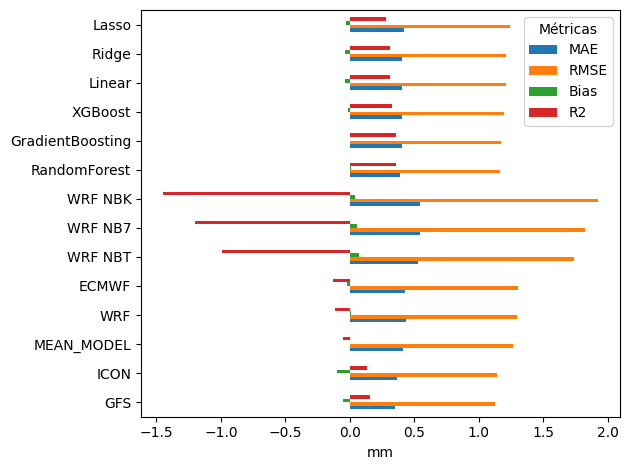

In [26]:
all_stats_df = pd.concat([stats_df, tuned_results_df.drop(columns=["train_time_s", "best_params"])])
statistical_metrics_plot(all_stats_df)

# 10 - Conclusões e próximos passos



**Em resumo:**
- O ensemble simples supera modelos individuais.
- Métodos baseados em árvores e boosting capturam melhor relações não lineares.
- Avaliação com múltiplas métricas foi essencial para compreender limitações e ganhos.

O experimento confirma que a combinação de dados meteorológicos com técnicas de aprendizado supervisionado agrega valor à previsão de precipitação, tornando-a mais robusta e confiável.

# 11 - Próximos passos
- **Organizar os valores de precipitação em acumulado diário.** Pode ser complexo acertar a distribuição de valores horários com exatidão tanto em termos de volume de chuva quanto em termos do momento de ocorrência. Já o acumulado diário, soma essa distribuição e pode representar melhor a chuva observada. Erram-se os horários, mas dentro do período o total se aproxima.
- **Aumentar o período de conjunto de dados.** Foram usados apenas 5 meses de previsão e dados observados. Esse período não aborda as diferentes estações do ano e não aborda variabilidades interanuais. Em termos estatísticos, o conjunto ainda é pequeno e pode não gerar um treinamneto muito robusto.
- **Criar features com lag de precipitação.** Por mais que a precipitação seja uma variável discreta, ou seja, não chove em H+1 por que choveu em H, essa informação pode representar um contexto climático que é já encontra-se favorável a chuva horas antes.
- **Adicionar outras variáveis como nebulosidade, umidade do ar e temperatura.**
- **Adicionar mais fontes de dados observados.** Isso possibilita alternativas quando um dado observado for nulo e também fontes mais confiáveis.